In [1]:
#%%
from dataclasses import dataclass, field
import numpy as np
from sklearn import metrics
import numpy as np
from tqdm import tqdm
import random
from typing import List, Dict
from sklearn.utils import resample
from scipy.special import expit
from shared import bootstrap_auc
from sklearn.model_selection import train_test_split

In [2]:
# start off by seeding random number generators:
RANDOM_SEED = 12345
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# import data; choose feature space
from dataset_poetry import y_train, Xd_train, y_vali, Xd_vali

X_train = Xd_train["numeric"]
X_vali = Xd_vali["numeric"]

In [3]:
#%%
from sklearn.linear_model import LogisticRegression

m = LogisticRegression(random_state=RANDOM_SEED, penalty="none", max_iter=2000)
m.fit(X_train, y_train)

print("skLearn-LR AUC: {:.3}".format(np.mean(bootstrap_auc(m, X_vali, y_vali))))
print("skLearn-LR Acc: {:.3}".format(m.score(X_vali, y_vali)))

skLearn-LR AUC: 0.973
skLearn-LR Acc: 0.929


In [ ]:
@dataclass
class LogisticRegressionModel:
    # Managed to squeeze bias into this weights array by adding some +1s.
    weights: np.ndarray

    @staticmethod
    def random(D: int) -> "LogisticRegressionModel":
        weights = np.random.randn(D + 1, 1)
        return LogisticRegressionModel(weights)

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        """ Compute the expit of the signed distance from the self.weights hyperplane. """
        (N, D) = X.shape
        assert self.weights[:D].shape == (D, 1)
        # Matrix multiplication; sprinkle transpose and assert to get the shapes you want (or remember Linear Algebra)... or both!
        output = np.dot(self.weights[:D].transpose(), X.transpose())
        assert output.shape == (1, N)
        # now add bias and put it through the 'S'/sigmoid/'expit' function.
        return np.array(expit(output + self.weights[-1])).ravel()

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array(self.decision_function(X) > 0.5, dtype="int32").ravel()

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """ Take predictions and compute accuracy. """
        y_hat = self.predict(X)
        return metrics.accuracy_score(np.asarray(y), y_hat)  # type:ignore


@dataclass
class ModelTrainingCurve:
    train: List[float] = field(default_factory=list)
    validation: List[float] = field(default_factory=list)

    def add_sample(
        self,
        m: LogisticRegressionModel,
        X: np.ndarray,
        y: np.ndarray,
        X_vali: np.ndarray,
        y_vali: np.ndarray,
    ) -> None:
        self.train.append(m.score(X, y))
        self.validation.append(m.score(X_vali, y_vali))


(N, D) = X_train.shape

learning_curves: Dict[str, ModelTrainingCurve] = {}


def compute_gradient_update(m, X, y) -> np.ndarray:
    """ Predict using m over X; compare to y, calculate the gradient update."""
    (N, D) = X.shape
    y_hat = m.decision_function(X)
    y_diffs = np.array(y_hat - y)
    # look at all the predictions to compute our derivative:
    gradient = np.zeros((D + 1, 1))

    # Literally a bajillion times faster if we ditch the for loops!
    # 1. scale X matrix by the y_diffs; then sum columns:
    x_scaled_by_y = X.T * y_diffs
    non_bias_gradient = np.sum(x_scaled_by_y, axis=1)
    gradient[:D] = non_bias_gradient.reshape((D, 1))
    # 2. the bias term is always 1 in X rows; so we just sum up the y_diffs for this.
    gradient[D] += np.sum(y_diffs)

    # take an gradient step in the negative direction ('down')
    return -(gradient / N)

In [39]:
def train_logistic_regression_gd(a, name="LR-GD", num_iter=100):
    plot = ModelTrainingCurve()
    learning_curves[name] = plot

    m = LogisticRegressionModel.random(D)
    # Alpha is the 'learning rate'.
    alpha = a

    for _ in tqdm(range(num_iter), total=num_iter, desc=name):
        # Each step is scaled by alpha, to control how fast we move, overall:
        m.weights += alpha * compute_gradient_update(m, X_train, y_train)
        # record performance:
        plot.add_sample(m, X_train, y_train, X_vali, y_vali)
    return m

m = train_logistic_regression_gd(a=1, num_iter=2000)
print("LR-GD AUC: {:.3}".format(np.mean(bootstrap_auc(m, X_vali, y_vali))))
print("LR-GD Acc: {:.3}".format(m.score(X_vali, y_vali)))

LR-GD: 100%|██████████| 2000/2000 [00:01<00:00, 1245.11it/s]


LR-GD AUC: 0.973
LR-GD Acc: 0.933


In [40]:
def train_logistic_regression_sgd_opt(a, name="LR-SGD", num_iter=100, minibatch_size=512):
    """ This is bootstrap-sampling minibatch SGD """
    plot = ModelTrainingCurve()
    learning_curves[name] = plot

    m = LogisticRegressionModel.random(D)
    alpha = a
    n_samples = max(1, N // minibatch_size)

    for _ in tqdm(range(num_iter), total=num_iter, desc=name):
        for _ in range(n_samples):
            X_mb, y_mb = resample(X_train, y_train, n_samples=minibatch_size)
            m.weights += alpha * compute_gradient_update(m, X_mb, y_mb)
        # record performance:
        plot.add_sample(m, X_train, y_train, X_vali, y_vali)
    return m

m = train_logistic_regression_sgd_opt(a=1, num_iter=2000)
print("LR-SGD AUC: {:.3}".format(np.mean(bootstrap_auc(m, X_vali, y_vali))))
print("LR-SGD Acc: {:.3}".format(m.score(X_vali, y_vali)))

LR-SGD: 100%|██████████| 2000/2000 [00:03<00:00, 659.73it/s]


LR-SGD AUC: 0.973
LR-SGD Acc: 0.931


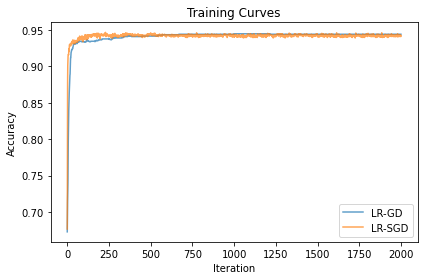

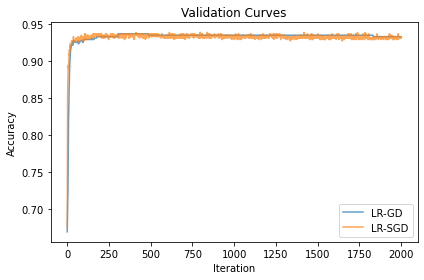

In [41]:
## Create training curve plots:
import matplotlib.pyplot as plt

for key, dataset in learning_curves.items():
    xs = np.array(list(range(len(dataset.train))))
    plt.plot(xs, dataset.train, label="{}".format(key), alpha=0.7)
plt.title("Training Curves")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("graphs/p12-training-curves.png")
plt.show()

## Create validation curve plots:
for key, dataset in learning_curves.items():
    xs = np.array(list(range(len(dataset.validation))))
    plt.plot(xs, dataset.validation, label="{}".format(key), alpha=0.7)
plt.title("Validation Curves")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("graphs/p12-vali-curves.png")
plt.show()

# TODO:
#
### 1. pick SGD or GD (I recommend SGD)

i looked at both

### 2. pick a smaller max_iter that gets good performance.

max_iter = 1000

##### Do either A or B:

##### (A) Explore Learning Rates:

##### 3. make ``alpha``, the learning rate, a parameter of the train function.

done

##### 4. make a graph including some faster and slower alphas:
##### .... alpha = [0.05, 0.1, 0.5, 1.0]
##### .... what do you notice?

The alpha of 1 converges faster than 0.05

##### (B) Explore 'Automatic/Early Stopping'

##### 3. split the 'training' data into **another** validation set.

##### 4. modify the SGD/GD loop to keep track of loss/accuarcy on this mini validation set at each iteration.
##### 5. add a tolerance parameter, and stop looping when the loss/accuracy on the mini validation set stops going down.